In [70]:
# ALGORYTM Z "Approximation of piecewise Hölder functions from inexact information"

# PARAMETRY ALGORYTMU:
# h = T/m, gdzie m >= 2r + 1   <--- initial resolution of the mesh
# 0 < w < (r + 1) * h

In [71]:
# Kroki algorytmu:
# 1. aproksymacja punktu osobliwego s_f
#   1a. siatka regularna (o długości h) oraz różnice dzielne użyte są do lokalizacji s_f na przedziale [u_1, v_1] (o długości (r+1) * h)
#   1b. zawęzenie przedziałów z 1a do [u_2, v_2] przy użyciu wielomianów ekstrpolacyjnych p_neg i p_pos
#   1c. wyprodukowanie przedziału [u_3, v_3] zawierającego się (lub równego) [u_2, v_2], w którym różnica |p_pos - p_neg| jest nierosnąca na [u_3, ksi] i niemalejąca na [ksi, v_3], gdzie ksi jest finalną aproksymacją s_f
# 2.

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy import interpolate

In [73]:
# EXAMPLE FUNCTION
T = 2 * np.pi + 0.5

def f(x):
    if 0 <= x < np.pi:
        return np.sin(x - np.pi)
    if np.pi <= x <= 2 * np.pi + 0.5:
        return np.sin(x - np.pi - 0.5)


In [74]:
# EXAMPLE FUNCTION
T = 3 * np.pi

def f(x):
    if 0 <= x < np.pi:
        return np.sin(x)
    if np.pi <= x <= 3 * np.pi:
        return np.sin(x - np.pi)

In [75]:
def d_noisy(i, r, t, y):
    '''t : array of data points t_i, ... , t_{i+r+1}
       y : array of y_j = f(t_j) + e_j  '''
    t.astype('float64')
    y.astype('float64')

    sum = np.float64(0.0)
    for j in range(i, i+r+1):

        product = 1.0
        for k in range(i, i+r+1):
            if k == j:
                continue
            product *= 1 / (t[k] - t[j])

        sum += y[j] * product

    return sum

In [76]:
# Step 1
def step1(t, y):
    i_max = np.argmax([d_noisy(i, r, t, y) for i in range(0, m-r)])
    u_1 = t[i_max]
    v_1 = t[i_max + r +1]
    return u_1, v_1, i_max

In [77]:
# Step 2
def step2(t, y, w, u_1, v_1, i_max):
    p_neg = interpolate.interp1d(
        t[i_max - r:i_max + 1],
        y[i_max - r:i_max + 1],
        fill_value="extrapolate"
    )
    p_pos = interpolate.interp1d(
        t[i_max + r + 1: i_max + 2 * r + 1 + 1],
        y[i_max + r + 1: i_max + 2 * r + 1 + 1],
        fill_value="extrapolate"
    )

    u = u_1
    v = v_1
    while v - u > w:
        z = np.array([u + j * (v - u) / (r + 2) for j in range(1, r + 2)])
        dif = np.abs(p_pos(z) - p_neg(z))
        j_max = np.argmax(dif)

        # tu chyba nie powinno byc bezposrednio f tylko f_noisy = f() + e
        if np.abs(f(z[j_max]) - p_neg(z[j_max])) <= np.abs(f(z[j_max]) - p_pos(z[j_max])):
            u = z[j_max]
        else:
            v = z[j_max]

    u_2 = u
    v_2 = v
    return u_2, v_2, p_neg, p_pos


In [78]:
# Step 3
def step3(t, y, u_2, v_2, p_neg, p_pos, u_1, v_1):
    u = u_2
    v = v_2

    def fun(x):
        return -1 * np.abs(p_neg(x) - p_pos(x))
        
    z_max = [0.0]   # it list only because we need to modify it inside of function (we cannot modify number)
    while True:
        result = minimize_scalar(fun=fun, bracket=(u,v))
        if not result.success:
            break
        
        z_max = result.x
        if np.abs(f(z_max) - p_neg(z_max)) <= np.abs(f(z_max) - p_pos(z_max)):
            u = z
        else:
            v = z

    u_3 = u
    v_3 = v
    # Final approximation (i use custom mesh to find argmin)
    mesh = np.arange(u_1, v_1, step=0.0005)
    x_array = [np.abs(p_pos(k) - p_neg(k)) for k in mesh]
    ksi = mesh[np.argmin(x_array)] # ksi is on x-asix

    # finding closest value to ksi in orginal mesh
    k = 0
    while ksi > t[k]:
        k += 1
    k = k if np.abs(ksi - t[k]) < np.abs(ksi - t[k+1]) else k+1
    ksi = t[k]

    return u_3, v_3, ksi


# x_array = np.append(t[:i_max-1], t[i_max:k], )

In [79]:
# ===ALGORITHM===
def alg3_inexact_info(f, r, T, m, delta):
    '''
    f - funkcja, którą aproksymujemy
    r - regularność funkcji
    T - dlugość przedziału (0,T]
    m - początkowa gęstość siatki
    delta - 
    '''
    # Step 0 (initialization of algorithm's constants and function evaluations)
    h = T / m
    w = -1.0 * np.random.uniform(-(r + 1) * h, 0) # multiply by -1 because we need interval (0, (r + 1) * h]

    t = np.linspace(0, T, m+1, dtype='float64') # czyli mamy m+1 wezlów postaci t[0], ... , t[m]
    e = np.random.uniform(-delta, delta, m+1)
    y = np.array([f(t[j]) + e[j] for j in range(0, m+1)])

    # kroki algorytmu
    u_1, v_1, i_max = step1(t, y)
    u_2, v_2, p_neg, p_pos = step2(t, y, w, u_1, v_1, i_max)
    u_3, v_3, ksi = step3(t, y, u_2, v_2, p_neg, p_pos, u_1, v_1)

    # finalna funkcja approksymująca podaną funkcję
    polynomial1 = interpolate.interp1d(
                t[:i_max + 1],
                y[:i_max + 1])

    polynomial2 = interpolate.interp1d(
                t[i_max + r + 1:],
                y[i_max + r + 1:])

    def final_approximation(x):
        if (t[0] <= x).all() and (x < u_1).all():
            return polynomial1(x)
        if (u_1 <= x).all() and (x < ksi).all():
            return p_neg(x)
        if (ksi <= x).all() and (x < v_1).all():
            return p_pos(x)
        if (v_1 <= x).all() and (x <= t[m]).all():
            return polynomial2(x)
    
    return t, final_approximation

In [80]:
delta = 10e-4
r = 2
m = 100

In [81]:
t, f_approximation = alg3_inexact_info(f, r, T, m, delta)

ipykernel_launcher:7: RuntimeWarning: overflow encountered in subtract


In [82]:
# function to calculate values of approximation function
def f_values(mesh, fun):
    values = []
    for x in mesh:
        values += [fun(x)]
    return np.array(values)

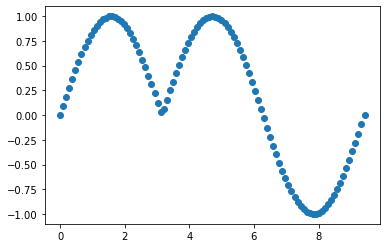

In [83]:
plt.scatter(t,f_values(t, f_approximation))

In [84]:
def worst_case_error(fun, x):
    '''
    calculate worst case error for function fun
    '''
    

    return np.abs(f(x) - f_approximation(x))

In [85]:
m_array = np.arange(10, 10**5, 100)